In [1]:
!pip install transformers pandas torch
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('github_issues.csv') #read the generated csv from github_issues notebook into a dataframe again here fro further processing

In [4]:
#split the null values and non-null values
labeled_df = df[df['Labels'].notnull()]
unlabeled_df = df[df['Labels'].isnull()]

#Extract the issue title and label values

issue_desc = labeled_df['Title'].tolist()
issue_labels = labeled_df[['activesupport', 'encryption', 'activerecord', 'With reproduction steps', 'attached PR', 'docs', 'activestorage', 'actionpack', 'rails foundation', 'railties', 'stale', 'pinned', 'activejob', 'PostgreSQL', 'actioncable', 'actionview', 'onhold', 'ci issues', 'actiontext', 'security', 'actionmailer', 'asset pipeline', 'third party issue', 'engines', 'routing', 'regression', 'MySQL', 'activemodel', 'parallel testing', 'needs work', 'needs feedback']].values

#extract test for unlabeled
issue_desc_val = unlabeled_df['Title'].tolist()

In [13]:
# Split into training and testing data (65/35 split)
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    issue_desc, issue_labels, test_size=0.35, random_state=42
)


In [14]:
import torch
from transformers import AutoTokenizer, DebertaForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")
model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base", problem_type="multi_label_classification")

# Tokenize training and validation data
train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
val_encodings = tokenizer(val_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Tokenize test data
test_encodings = tokenizer(issue_desc_val, padding=True, truncation=True, max_length=512, return_tensors="pt")

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Dataset for labeled data
class MultiLabelDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

# Dataset for test data (no labels needed)
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

# Create datasets
train_dataset = MultiLabelDataset(train_encodings, train_labels)
val_dataset = MultiLabelDataset(val_encodings, val_labels)
test_dataset = TestDataset(test_encodings)


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 1, Training Loss: 0.5250, Precision: 0.0882, Recall: 0.2761, F1: 0.1337


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 1, Validation Loss: 0.2981, Precision: 0.4901, Recall: 0.2349, F1: 0.3176


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 2, Training Loss: 0.2370, Precision: 0.5484, Recall: 0.2708, F1: 0.3626


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 2, Validation Loss: 0.1929, Precision: 0.4901, Recall: 0.2349, F1: 0.3176


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 3, Training Loss: 0.1703, Precision: 0.5469, Recall: 0.1858, F1: 0.2774


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 3, Validation Loss: 0.1729, Precision: 0.4901, Recall: 0.2349, F1: 0.3176


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 4, Training Loss: 0.1580, Precision: 0.5336, Recall: 0.2673, F1: 0.3561


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 4, Validation Loss: 0.1685, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 5, Training Loss: 0.1543, Precision: 0.4950, Recall: 0.2619, F1: 0.3426


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 5, Validation Loss: 0.1664, Precision: 0.4967, Recall: 0.2413, F1: 0.3248


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 6, Training Loss: 0.1516, Precision: 0.5528, Recall: 0.3150, F1: 0.4014


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 6, Validation Loss: 0.1666, Precision: 0.6087, Recall: 0.1778, F1: 0.2752


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 7, Training Loss: 0.1476, Precision: 0.6111, Recall: 0.2531, F1: 0.3579


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 7, Validation Loss: 0.1616, Precision: 0.5625, Recall: 0.3429, F1: 0.4260


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 8, Training Loss: 0.1433, Precision: 0.6889, Recall: 0.3292, F1: 0.4455


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 8, Validation Loss: 0.1613, Precision: 0.5938, Recall: 0.2413, F1: 0.3431


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 9, Training Loss: 0.1336, Precision: 0.7574, Recall: 0.3646, F1: 0.4922


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 9, Validation Loss: 0.1547, Precision: 0.6769, Recall: 0.2794, F1: 0.3955


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 10, Training Loss: 0.1259, Precision: 0.7799, Recall: 0.4265, F1: 0.5515


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 10, Validation Loss: 0.1561, Precision: 0.6395, Recall: 0.2984, F1: 0.4069


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 11, Training Loss: 0.1199, Precision: 0.8210, Recall: 0.4708, F1: 0.5984


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 11, Validation Loss: 0.1553, Precision: 0.5920, Recall: 0.3778, F1: 0.4612


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 12, Training Loss: 0.1148, Precision: 0.8415, Recall: 0.4885, F1: 0.6181


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 12, Validation Loss: 0.1566, Precision: 0.6193, Recall: 0.3460, F1: 0.4440


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 13, Training Loss: 0.1112, Precision: 0.8364, Recall: 0.5699, F1: 0.6779


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 13, Validation Loss: 0.1576, Precision: 0.6127, Recall: 0.3968, F1: 0.4817


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 14, Training Loss: 0.1064, Precision: 0.8840, Recall: 0.5664, F1: 0.6904


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 14, Validation Loss: 0.1581, Precision: 0.6080, Recall: 0.3841, F1: 0.4708


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 15, Training Loss: 0.1044, Precision: 0.8966, Recall: 0.5982, F1: 0.7176


<ipython-input-15-73b36484b6ed>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 15, Validation Loss: 0.1584, Precision: 0.6029, Recall: 0.3905, F1: 0.4740


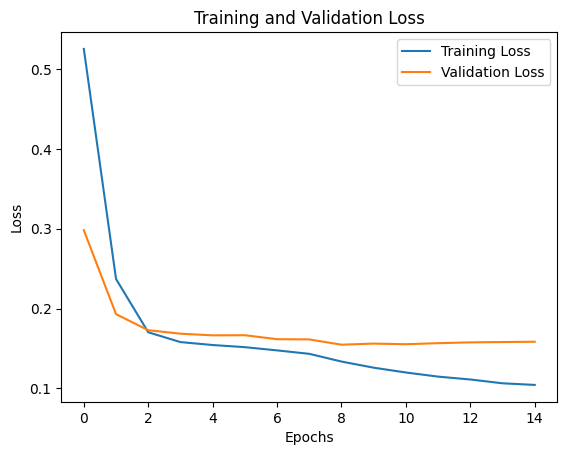

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def compute_metrics(preds, labels, threshold=0.5):
    # Apply thresholding to get binary predictions
    preds = (preds > threshold).astype(int)

    # Calculate Precision, Recall, and F1 score
    precision = precision_score(labels, preds, average='micro')
    recall = recall_score(labels, preds, average='micro')
    f1 = f1_score(labels, preds, average='micro')

    return precision, recall, f1

# Training loop
train_precisions, train_recalls, train_f1s = [], [], []
val_precisions, val_recalls, val_f1s = [], [], []
train_losses, val_losses = [], []


# Load DeBERTa model
num_labels = train_labels.shape[1]
model = DebertaForSequenceClassification.from_pretrained(
    "microsoft/deberta-base", num_labels=num_labels, problem_type="multi_label_classification"
)

# Move model to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=6e-5)




# Training loop
from torch.utils.data import DataLoader
from transformers import get_scheduler

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
epochs = 15
num_training_steps = epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=3, num_training_steps=num_training_steps
)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    all_train_preds = []
    all_train_labels = []

    for batch in train_loader:
        batch = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        train_loss += loss.item()

        # Collect predictions and labels for metrics calculation
        all_train_preds.append(torch.sigmoid(logits).clone().detach().cpu().numpy())
        all_train_labels.append(batch['labels'].clone().detach().cpu().numpy())

    # Calculate metrics after training
    all_train_preds = np.concatenate(all_train_preds, axis=0)
    all_train_labels = np.concatenate(all_train_labels, axis=0)
    precision, recall, f1 = compute_metrics(all_train_preds, all_train_labels)
    train_losses.append(train_loss / len(train_loader))
    train_precisions.append(precision)
    train_recalls.append(recall)
    train_f1s.append(f1)

    print(f"Epoch {epoch + 1}, Training Loss: {train_loss / len(train_loader):.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []

    for batch in val_loader:
        batch = {key: val.to(device) for key, val in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
            val_loss += outputs.loss.item()

            # Collect predictions and labels for metrics calculation
            all_val_preds.append(torch.sigmoid(logits).clone().detach().cpu().numpy())
            all_val_labels.append(batch['labels'].clone().detach().cpu().numpy())

    # Calculate metrics after validation
    all_val_preds = np.concatenate(all_val_preds, axis=0)
    all_val_labels = np.concatenate(all_val_labels, axis=0)
    precision, recall, f1 = compute_metrics(all_val_preds, all_val_labels)
    val_losses.append(val_loss / len(val_loader))
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1s.append(f1)

    print(f"Epoch {epoch + 1}, Validation Loss: {val_loss / len(val_loader):.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

import matplotlib.pyplot as plt

# Plot training and validation loss
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Call this function after training is done
plot_losses(train_losses, val_losses)


In [17]:

# Create DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=16)

# Predict
model.eval()
predictions = []

with torch.no_grad():
    for batch in test_loader:
        batch = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.sigmoid(logits).cpu().numpy()  # Convert logits to probabilities
        predictions.extend(preds)

# Threshold to convert probabilities to binary labels (e.g., threshold = 0.5)
threshold = 0.5
binary_predictions = (np.array(predictions) >= threshold).astype(int)

# Add predicted labels to the unlabeled dataframe
unlabeled_df['predicted_labels'] = binary_predictions.tolist()

# Save to a file
unlabeled_df.to_csv("predicted_labels.csv", index=False)


<ipython-input-15-73b36484b6ed>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-17-039ff0c88837>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled_df['predicted_labels'] = binary_predictions.tolist()


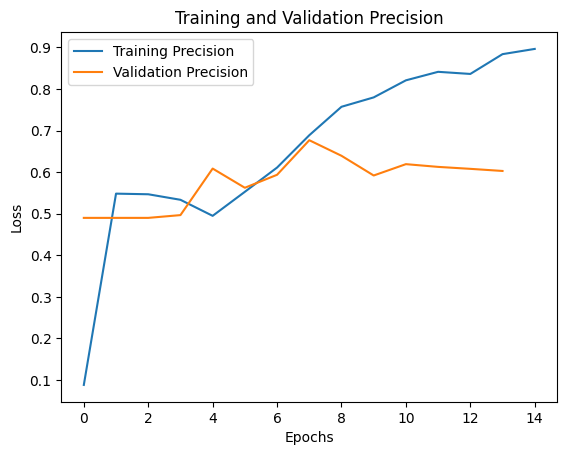

In [26]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training Precision')
    plt.plot(val_losses, label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Precision')
    plt.show()

# Call this function after training is done
plot_losses(train_precisions, val_precisions)


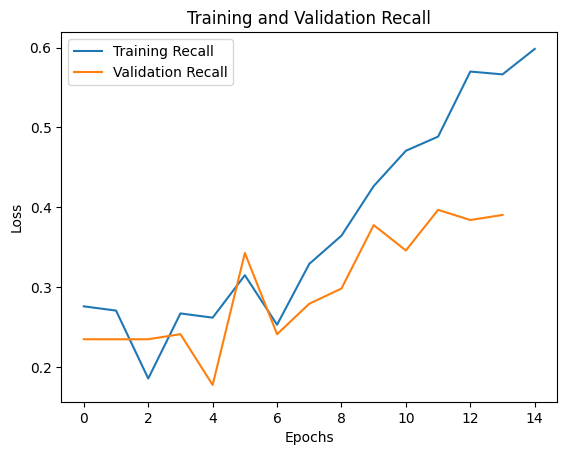

In [27]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training Recall')
    plt.plot(val_losses, label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Recall')
    plt.show()

# Call this function after training is done
plot_losses(train_recalls, val_recalls)

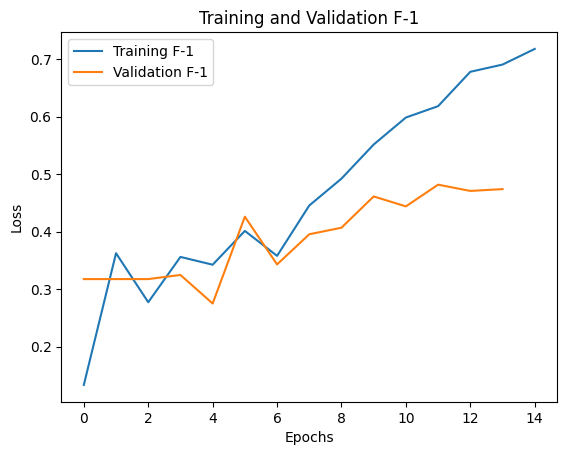

In [28]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training F-1')
    plt.plot(val_losses, label='Validation F-1')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation F-1')
    plt.show()

# Call this function after training is done
plot_losses(train_f1s, val_f1s)

References:

Note : I utlized GPT-4o, Hugging Face website and Colab to help me write parts of the code here such as Loading the model, Dataset class, help in calculating metrics (precision, recall etc.)
